In [91]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud
# Compute cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset from CSV
def load_dataset(json_file):
    return pd.read_json(json_file, lines=True)

# Text preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

# Generate BERT embeddings for sentences
def generate_sentence_embeddings(sentences):
    model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens', device='cuda:0')
    embeddings = model.encode(sentences)
    return embeddings

# Perform clustering using KMeans
def perform_clustering(embeddings, num_clusters):
    cosine_similarities = cosine_similarity(embeddings, embeddings)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(cosine_similarities)
    return kmeans.labels_, kmeans.inertia_

def knn_elbow_method(embeddings, min_iter=3, max_iter=10):
    inertias = []
    for i in range(min_iter, max_iter):
        labels, inertia = perform_clustering(embeddings, i)
        inertias.append(inertia)
    plt.plot(np.arange(min_iter, max_iter), inertias)
    plt.title('KNN elbow')
    plt.show()


# Visualize clusters
def visualize_clusters(embeddings, labels):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Cluster Visualization')
    plt.show()

def visualize_clusters_3D(embeddings, labels):
    pca = PCA(n_components=3)
    pca_embeddings = pca.fit_transform(embeddings)
    plt.axes(projection = '3d')
    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], pca_embeddings[:, 2], c=labels, cmap='viridis')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Cluster Visualization')
    plt.show()
    

[nltk_data] Downloading package punkt to /home/nacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nacho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
# Load dataset
dataset = load_dataset('department_justice_press_releases.json')

In [93]:
# Preprocess corpus
#dataset['preprocessed_corpus'] = dataset['contents'].apply(preprocess_text)

In [94]:
# Generate BERT embeddings
#embeddings = generate_sentence_embeddings(dataset['preprocessed_corpus'])
embeddings = generate_sentence_embeddings(dataset['contents'])

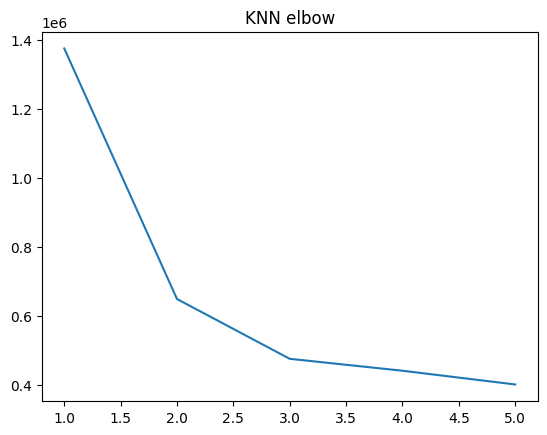

In [95]:
knn_elbow_method(embeddings, min_iter=1, max_iter=6)

In [96]:
# Perform clustering
num_clusters = 3 # You can adjust this number
labels, _ = perform_clustering(embeddings, num_clusters)

/home/nacho/Documentos/Master/social-media-mining/.venv/lib/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


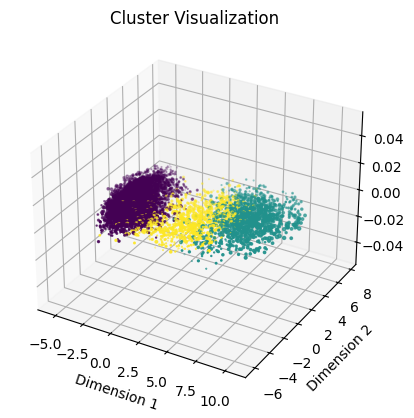

In [97]:
# Visualize clusters
visualize_clusters_3D(embeddings, labels)

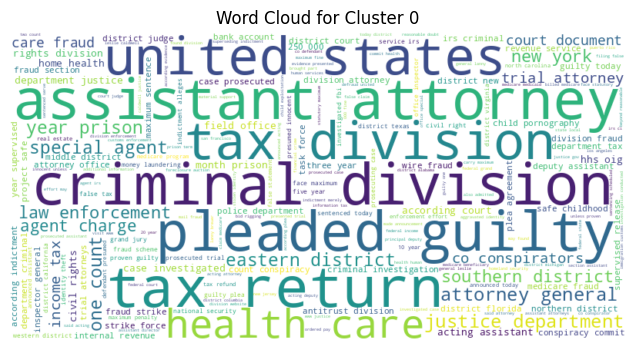

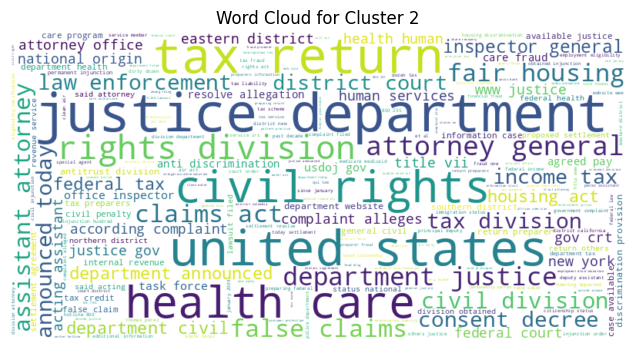

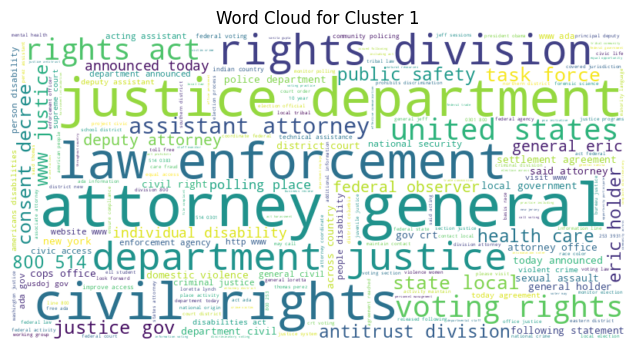

In [98]:
def visualize_clusters_wordcloud(documents, labels):
    # Group documents by cluster label
    clustered_documents = {}
    for doc, label in zip(documents, labels):
        if label not in clustered_documents:
            clustered_documents[label] = []
        clustered_documents[label].append(doc)
    
    # TF-IDF Calculation for each cluster
    wordclouds = {}
    for cluster_label, docs in clustered_documents.items():
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))
        tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        
        # Calculate average TF-IDF scores for each word in the cluster
        avg_tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
        
        # Map feature names to their average TF-IDF scores
        word_tfidf_scores = {feature_names[j]: avg_tfidf_scores[j] for j in range(len(feature_names))}
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white')
        wordcloud.generate_from_frequencies(word_tfidf_scores)
        
        # Store word cloud for the cluster
        wordclouds[cluster_label] = wordcloud
    
    # Plot word clouds for each cluster
    for cluster_label, wordcloud in wordclouds.items():
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud for Cluster {}'.format(cluster_label))
        plt.axis('off')
        plt.show()
        
dataset['preprocessed_corpus'] = dataset['contents'].apply(preprocess_text)
visualize_clusters_wordcloud(dataset['preprocessed_corpus'], labels)